In [1]:
!pip install torch torchvision torchaudio --upgrade
!pip install accelerate
!pip install accelerate --upgrade
!pip install torch torchvision torchaudio --upgrade


!pip install transformers --upgrade
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd

df = pd.read_csv('labeled_comments_cleaned.csv')

In [3]:
import re

# Function to clean text data
def clean_text(text):
    # Remove symbols and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = text.strip()
    return text

# Clean the comment_full_text column
df['comment_full_text'] = df['comment_full_text'].apply(clean_text)

In [4]:
df.head()

,file_id,comment_id,comment_date,anonymized_nickname,document_paragraph_text,document_selected_text,document_selected_sentences,comment_full_text,comment_sentence_text,is_sentence,...,spelling_errors,tracked_changes,next_action,level_0,level_1,level_2,level_3,level_4,date_column,time_column
0,ed88fa24-1a89-44fb-9a66-c7f554d87f5d,ffc97358-69e6-48fb-aaf0-6a844e26f653,2013-04-09 09:30:00+00:00 00:00:00+00:00,Editor,The experiments were carried out in a fluidize...,NaN,1.0,ok,Ok?,0,...,0.0,2.0,KEEP,INFORMATION EXCHANGE,REQUESTED,REQUESTING_CONFIRMATION,POTENTIAL_CHANGE,NaN,2013-04-09,09:30:00
1,0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e,ffa706dc-4877-492d-ac74-598d5f4d07c5,2011-12-08 15:51:00+00:00 00:00:00+00:00,Alicia R. Dalton-Tingler,"In addition to the work mentioned above, the E...",NaN,1.0,this has been discussed in the executive summa...,This has been discussed in the Executive Summa...,1,...,0.0,1.0,KEEP,MODIFICATION,EXECUTION,PROMISE,NaN,NaN,2011-12-08,15:51:00
2,0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e,ffa706dc-4877-492d-ac74-598d5f4d07c5,2011-12-08 15:51:00+00:00 00:00:00+00:00,Alicia R. Dalton-Tingler,"In addition to the work mentioned above, the E...",NaN,1.0,this has been discussed in the executive summa...,"It is, however, very out of place sitting here.",1,...,0.0,1.0,KEEP,SOCIAL COMMUNICATION,DISCUSSION,CONTENT,NOT_POTENTIAL_CHANGE,NaN,2011-12-08,15:51:00
3,0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e,ffa706dc-4877-492d-ac74-598d5f4d07c5,2011-12-08 15:51:00+00:00 00:00:00+00:00,Alicia R. Dalton-Tingler,"In addition to the work mentioned above, the E...",NaN,1.0,this has been discussed in the executive summa...,This has been discussed in the Executive Summa...,0,...,0.0,1.0,KEEP,MODIFICATION,REQUESTED,CONTENT,EXPLICIT,NaN,2011-12-08,15:51:00
4,f5208894-9572-4cb8-b023-00b3c03cee89,ff533813-4050-424d-8e01-3c8dbb392f4d,2016-03-09 15:05:00+00:00 00:00:00+00:00,Alannah Kittle,NaN,NaN,1.0,coding\n\ncode qualitative data for wavguagea,CODING\n\nCode qualitative data for WAVGUAGE03A,0,...,0.0,0.0,KEEP,INFORMATION EXCHANGE,PROVIDED,REFERENCE,POTENTIAL_CHANGE,NaN,2016-03-09,15:05:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4991 entries, 0 to 4990
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   file_id                      4991 non-null   object 
 1   comment_id                   4991 non-null   object 
 2   comment_date                 4991 non-null   object 
 3   anonymized_nickname          4976 non-null   object 
 4   document_paragraph_text      4502 non-null   object 
 5   document_selected_text       3990 non-null   object 
 6   document_selected_sentences  4991 non-null   float64
 7   comment_full_text            4991 non-null   object 
 8   comment_sentence_text        4991 non-null   object 
 9   is_sentence                  4991 non-null   int64  
 10  num_sentence                 4991 non-null   int64  
 11  total_sentences              4991 non-null   int64  
 12  grammar_checked              4991 non-null   int64  
 13  grammatical_errors

XML_CNN (Level_0 and Level_1)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# Load dataset
df_1 = pd.read_csv('labeled_comments_cleaned.csv')

# Ensure all entries are strings and handle NaNs
df_1['level_0'] = df_1['level_0'].astype(str)
df_1['level_1'] = df_1['level_1'].astype(str)

# Combine two label columns into a list of labels per row
df_1['combined_labels'] = df_1[['level_0', 'level_1']].apply(lambda row: [x for x in row if x != 'nan'], axis=1)

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_1['combined_labels'])

# Selecting the feature variable
X = df_1['comment_full_text']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the TextDataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokenized = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = tokenized['input_ids'].squeeze(0)
        attention_mask = tokenized['attention_mask'].squeeze(0)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.FloatTensor(label)
        }

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create dataset and dataloader
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class XMLCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_labels, num_filters, filter_sizes):
        super(XMLCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embed_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_labels)

    def forward(self, input_ids):
        x = self.embedding(input_ids)  # [batch_size, sequence_length, embed_dim]
        x = x.unsqueeze(1)  # Add channel dimension [batch_size, 1, sequence_length, embed_dim]
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # Apply convolution and ReLU
        x = [F.max_pool1d(line, line.size(2)).squeeze(2) for line in x]  # Max pooling over the time dimension
        x = torch.cat(x, 1)  # Concatenate along the filter dimension
        x = self.fc(x)
        return x

# Initialize the XML-CNN model
vocab_size = tokenizer.vocab_size
embed_dim = 128
num_labels = y_train.shape[1]
num_filters = 100
filter_sizes = [3, 4, 5]

model = XMLCNN(vocab_size, embed_dim, num_labels, num_filters, filter_sizes)


In [8]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch['input_ids'])
        loss = criterion(outputs, batch['labels'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')


Epoch 1, Loss: 0.30114207804203036
Epoch 2, Loss: 0.2138398540019989
Epoch 3, Loss: 0.17487518471479416
Epoch 4, Loss: 0.15713647240400314
Epoch 5, Loss: 0.1514855129122734
Epoch 6, Loss: 0.14139523145556449
Epoch 7, Loss: 0.13353335729241372
Epoch 8, Loss: 0.13098827615380287
Epoch 9, Loss: 0.13804612645506859
Epoch 10, Loss: 0.12756854364275932


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            outputs = model(batch['input_ids'])
            predicted_labels = torch.sigmoid(outputs) > 0.5
            true_labels.append(batch['labels'].cpu())
            predictions.append(predicted_labels.cpu())

    true_labels = torch.cat(true_labels, dim=0).numpy()
    predictions = torch.cat(predictions, dim=0).numpy()

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='micro')
    recall = recall_score(true_labels, predictions, average='micro')
    f1 = f1_score(true_labels, predictions, average='micro')

    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Evaluate the model
evaluate_model(model, test_loader)


Accuracy: 0.5885885885885885, Precision: 0.745141588006663, Recall: 0.6953367875647668, F1 Score: 0.719378182792817


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error
def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    predictions = []
    outputs_list = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids']
            labels = batch['labels']
            outputs = model(inputs)
            predicted_labels = torch.sigmoid(outputs) > 0.5
            true_labels.append(labels.cpu())
            predictions.append(predicted_labels.cpu())
            outputs_list.append(torch.sigmoid(outputs).cpu())

    # Concatenate all the results
    true_labels = torch.cat(true_labels, dim=0).numpy()
    predictions = torch.cat(predictions, dim=0).numpy()
    outputs_list = torch.cat(outputs_list, dim=0).numpy()

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='micro')
    recall = recall_score(true_labels, predictions, average='micro')
    f1 = f1_score(true_labels, predictions, average='micro')
    mse = mean_squared_error(true_labels, outputs_list)
    test_error_rate = 1 - accuracy
    conf_matrix = confusion_matrix(true_labels.argmax(axis=1), predictions.argmax(axis=1))

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Mean Squared Error: {mse}")
    print(f"Test Error Rate: {test_error_rate}")
    print("Confusion Matrix:")
    print(conf_matrix)

# Call the evaluation function
evaluate_model(model, test_loader)


Accuracy: 0.5885885885885885
Precision: 0.745141588006663
Recall: 0.6953367875647668
F1 Score: 0.719378182792817
Mean Squared Error: 0.07970108836889267
Test Error Rate: 0.41141141141141147
Confusion Matrix:
[[  3   2   0   0   0   0   0   1   0   0]
 [  3  13   0   1   8   3   0   0   3   1]
 [  6   1  32   1   6  17   0   0   1   1]
 [  1   5   0  20   6   1   0   0   5   5]
 [ 16   2   3   5 383  82   0   0  17   0]
 [  9   3   0   5  52 195   3   1   9   0]
 [ 15   0   0   1   9   1  41   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


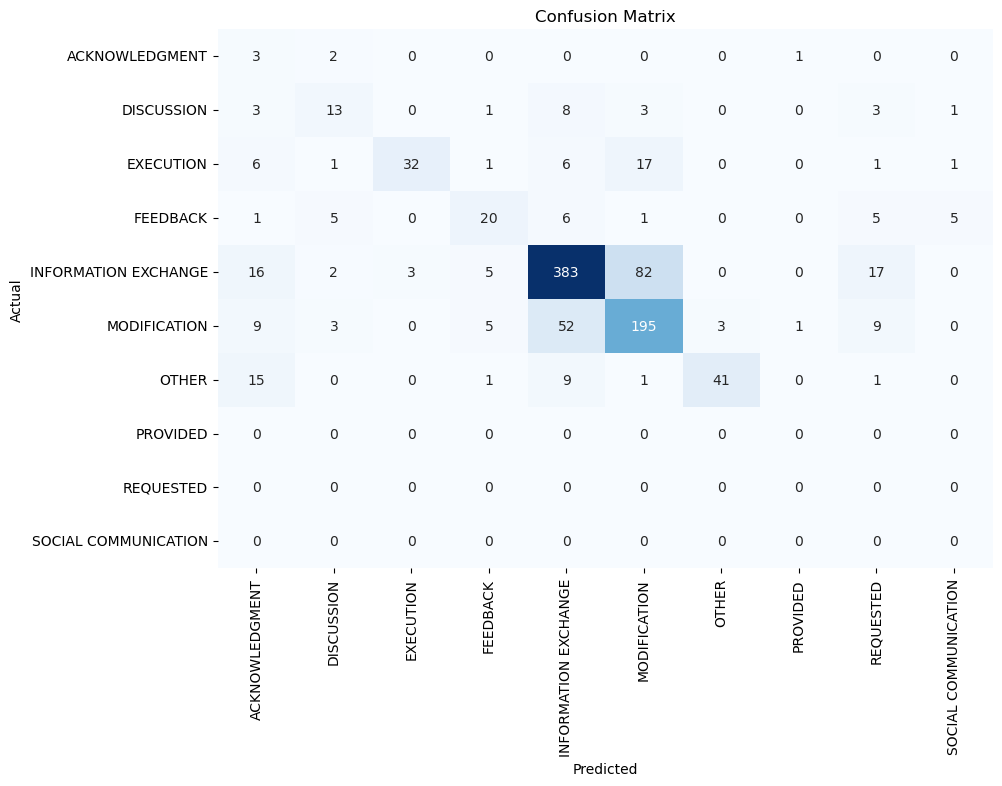

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

def get_predictions_and_true_labels(model, data_loader):
    model.eval()
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            inputs, true_labels = batch['input_ids'], batch['labels']
            logits = model(inputs)
            predictions = torch.sigmoid(logits) > 0.5
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(true_labels.cpu().numpy())
    
    return np.array(all_true_labels), np.array(all_predictions)

def plot_confusion_matrix(true_labels, predictions, class_names):
    # Flatten the one-hot encoded labels to a single label per example
    true_labels = np.argmax(true_labels, axis=1)
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

true_labels, predictions = get_predictions_and_true_labels(model, test_loader)


class_names = mlb.classes_  # mlb is your MultiLabelBinarizer

plot_confusion_matrix(true_labels, predictions, class_names)


In [12]:
def predict_text(model, tokenizer, text, class_names, max_len=512, threshold=0.5):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Prepare the text input for the model
    with torch.no_grad():
        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = inputs['input_ids']
        
        # Forward pass to get logits
        outputs = model(input_ids)
        
        # Convert logits to probabilities using sigmoid function
        probabilities = torch.sigmoid(outputs).squeeze(0)
        
        # Apply threshold to determine labels presence
        predictions = (probabilities > threshold).int()
        
        # Map predictions to class names
        predicted_labels = [class_names[i] for i, pred in enumerate(predictions) if pred == 1]

    return predicted_labels, probabilities

# Example usage:
text = "Can we set up a meeting to review these results?"
class_names = mlb.classes_ 
predicted_labels, probabilities = predict_text(model, tokenizer, text, class_names)
print(f"Predicted labels for 'level_0' and 'level_1': {predicted_labels}")
print(f"Probabilities for each class: {probabilities}")


Predicted labels for 'level_0' and 'level_1': ['INFORMATION EXCHANGE', 'REQUESTED']
Probabilities for each class: tensor([1.7776e-03, 1.4441e-02, 3.5507e-04, 5.5614e-04, 9.6065e-01, 7.7907e-03,
        5.6822e-04, 9.9552e-04, 9.9349e-01, 8.5216e-03])


In [13]:
torch.save(model.state_dict(), 'path_to_saved_model.pth')


In [14]:
model = XMLCNN(vocab_size, embed_dim, num_labels, num_filters, filter_sizes)
model.load_state_dict(torch.load('path_to_saved_model.pth'))
model.eval()


XMLCNN(
  (embedding): Embedding(30522, 128)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 128), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 128), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 128), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=10, bias=True)
)

In [15]:
new_text = "Congratulations on your recent project success!"
predicted_labels, probabilities = predict_text(model, tokenizer, new_text, class_names)
print(f"Predicted Labels: {predicted_labels}")
print(f"Probabilities: {probabilities}")


Predicted Labels: []
Probabilities: tensor([0.0058, 0.0189, 0.0080, 0.1354, 0.0549, 0.2644, 0.0023, 0.0234, 0.3758,
        0.3450])


In [16]:
new_text = "This has been discussed in the Executive Summary via a table and will likely be covered in great depth later in this report."
predicted_labels, probabilities = predict_text(model, tokenizer, new_text, class_names)
print(f"Predicted Labels: {predicted_labels}")
print(f"Probabilities: {probabilities}")

Predicted Labels: ['MODIFICATION']
Probabilities: tensor([2.3297e-04, 1.6089e-01, 1.6134e-01, 4.5476e-02, 4.3764e-02, 6.9017e-01,
        2.7298e-04, 1.8364e-02, 4.3487e-01, 3.2408e-01])


Bert

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Load dataset
df = pd.read_csv('labeled_comments_cleaned.csv')

# Ensure all data in 'level_0' and 'level_1' are strings, and handle NaNs
df['level_0'] = df['level_0'].fillna('Unknown').astype(str)
df['level_1'] = df['level_1'].fillna('Unknown').astype(str)

# Combine two label columns into a list of labels per row
df['combined_labels'] = df.apply(lambda row: [row['level_0'], row['level_1']], axis=1)

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['combined_labels'].values.tolist())

# Selecting the feature variable
X = df['comment_full_text']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
from transformers import BertForSequenceClassification, AdamW

# Load the BERT model, specifying the number of output labels
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=y_train.shape[1],  # Number of output labels in the last layer for multi-label classification
    output_attentions=False,      # Whether the model returns attentions weights.
    output_hidden_states=False,   # Whether the model returns all hidden-states.
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
from torch.utils.data import DataLoader

train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [20]:
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = BCEWithLogitsLoss()

# Training loop
model.train()
for epoch in range(10):  # Set number of epochs
    total_loss = 0
    for batch in train_loader:
        batch_input_ids = batch['input_ids'].to(device)
        batch_attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        model.zero_grad()        
        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_mask)
        
        loss = criterion(outputs.logits, batch_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.2f}")


Average training loss: 0.34
Average training loss: 0.21
Average training loss: 0.17
Average training loss: 0.14
Average training loss: 0.13
Average training loss: 0.12
Average training loss: 0.12
Average training loss: 0.11
Average training loss: 0.11
Average training loss: 0.10


In [21]:
# Save the model weights
model.save_pretrained('./model_save')

# Save the tokenizer
tokenizer.save_pretrained('./model_save')


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [22]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the model
model = BertForSequenceClassification.from_pretrained('./model_save')

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('./model_save')

# Ensure you move the model to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    predictions, true_labels, probabilities = [], [], []

    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            logits = outputs.logits
            sigmoid_outputs = torch.sigmoid(logits)
            probabilities.append(sigmoid_outputs.cpu().numpy())
            pred_bools = (sigmoid_outputs > 0.5).cpu().numpy()
            predictions.append(pred_bools)
            true_labels.append(labels.cpu().numpy())

    # Flatten the predictions and true labels lists
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)
    probabilities = np.vstack(probabilities)

    # Calculate Metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='micro')
    recall = recall_score(true_labels, predictions, average='micro')
    f1 = f1_score(true_labels, predictions, average='micro')
    mse = mean_squared_error(true_labels, probabilities)
    test_error_rate = 1 - accuracy
    conf_matrix = confusion_matrix(true_labels.argmax(axis=1), predictions.argmax(axis=1))

    print(f"Loss: {total_loss / len(data_loader):.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Test Error Rate: {test_error_rate:.4f}")
    print("Confusion Matrix:\n", conf_matrix)

# Criterion for loss computation
criterion = torch.nn.BCEWithLogitsLoss()

# Evaluate the model
evaluate_model(model, test_loader, criterion, device)


Loss: 0.2248
Accuracy: 0.6897
Precision: 0.7797
Recall: 0.7548
F1 Score: 0.7670
Mean Squared Error: 0.0618
Test Error Rate: 0.3103
Confusion Matrix:
 [[  1   3   0   1   1   0   0   0   0]
 [  4  14   0   0   6   3   1   0   4]
 [  0   2  51   1   4   7   0   0   0]
 [  4   6   0  25   2   1   0   1   4]
 [  1   3   3   0 392 102   0   2   5]
 [  1   3   5   1  48 207   1   7   4]
 [  1   0   1   0  12   3  51   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]


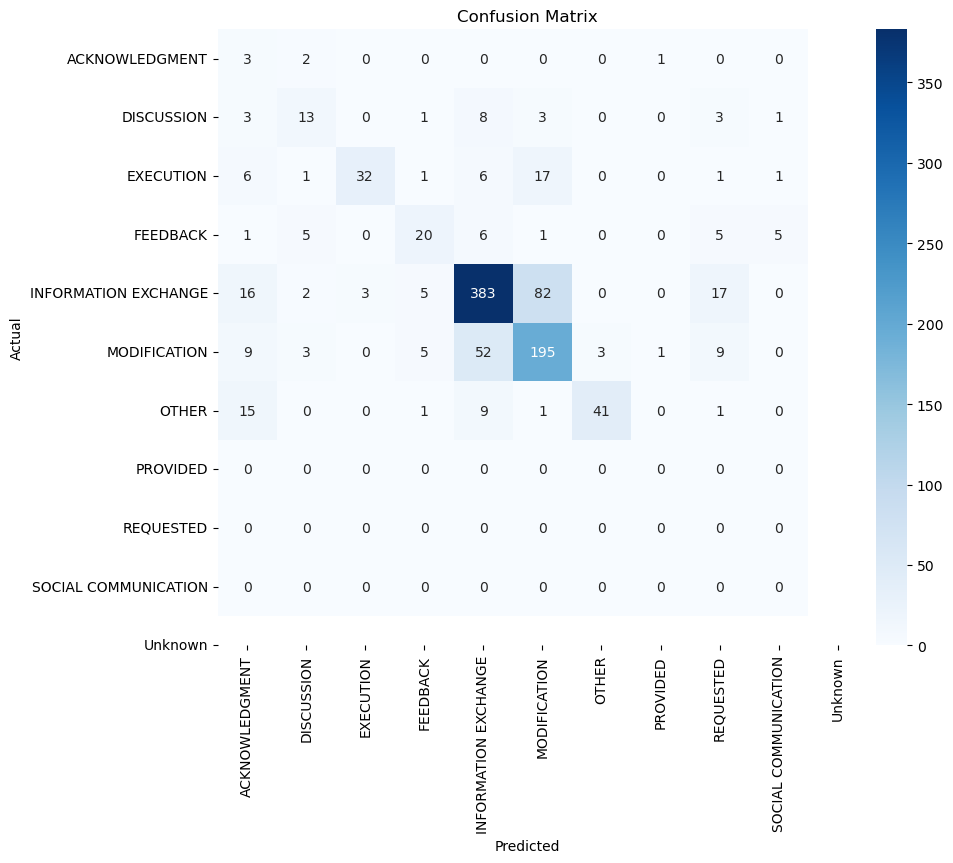

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(true_labels.argmax(axis=1), predictions.argmax(axis=1))

# Define the class names for your model's classes
class_names = mlb.classes_

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Adding labels and title
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [25]:
def predict(text):
    model.eval()  # Put the model in evaluation mode
    inputs = tokenizer(text, return_tensors="pt", max_length=512, padding='max_length', truncation=True)

    # Move tensors to the right device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.sigmoid(outputs.logits).squeeze()

    return probabilities

# Example use
text = "This has been discussed in the Executive Summary via a table and will likely be covered in great depth later in this report."
probabilities = predict(text)
print(probabilities)


tensor([0.0023, 0.0077, 0.0762, 0.0059, 0.6459, 0.3140, 0.0013, 0.8604, 0.0426,
        0.0092, 0.0010], device='cuda:0')


In [26]:
from transformers import BertTokenizer, BertForSequenceClassification

model_path = "bert_model"
model.save_pretrained(model_path)

tokenizer_path = "bert_tokenizer"
tokenizer.save_pretrained(tokenizer_path)


('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json')

In [27]:
# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

# Move model to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()  # Set the model to evaluation mode


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [28]:
def predict_text(text, model, tokenizer, class_names, max_len=512):
    model.eval()  # Ensure model is in eval mode for inference

    # Prepare the text input for the model
    encoded_input = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).squeeze()

    # Convert probabilities to binary predictions
    predictions = (probs > 0.5).cpu().numpy()
    predicted_labels = [class_names[i] for i, pred in enumerate(predictions) if pred]

    return predicted_labels, probs.cpu().numpy()

# Example usage
text = "Changed from 6 grades per nine weeks to 10"
class_names = mlb.classes_  # Your class names from MultiLabelBinarizer
predicted_labels, probabilities = predict_text(text, model, tokenizer, class_names)
print("Predicted Labels:", predicted_labels)


Predicted Labels: ['EXECUTION', 'MODIFICATION']


BART

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import DataLoader, Dataset
import torch
from transformers import BartTokenizer, BartForSequenceClassification, AdamW

# Load the datasetAC
df = pd.read_csv('labeled_comments_cleaned.csv')

# Handle missing values and ensure all data are strings
df.fillna('Unknown', inplace=True)
df['level_0'] = df['level_0'].astype(str)
df['level_1'] = df['level_1'].astype(str)

# Combine the label columns into a list of labels per row
df['combined_labels'] = df[['level_0', 'level_1']].apply(lambda x: list(x), axis=1)

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['combined_labels'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df['comment_full_text'], labels, test_size=0.2, random_state=42)

# Define the dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Load the tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Create DataLoaders
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [30]:
# Initialize the BART model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BartForSequenceClassification.from_pretrained('facebook/bart-base', num_labels=labels.shape[1])
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Train the model
model.train()
for epoch in range(10):  # Number of epochs
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/spati/.local/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.25728267477545325
Epoch 2, Loss: 0.1943675659537196
Epoch 3, Loss: 0.1639520483789499
Epoch 4, Loss: 0.14840196877464146
Epoch 5, Loss: 0.13744817569269566
Epoch 6, Loss: 0.13059574374014546
Epoch 7, Loss: 0.1263214381419137
Epoch 8, Loss: 0.11845145445085599
Epoch 9, Loss: 0.1142450406818925
Epoch 10, Loss: 0.10986273400186895


In [31]:
model.save_pretrained('path_to_save_bart_model')
tokenizer.save_pretrained('path_to_save_bart_tokenizer')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('path_to_save_bart_tokenizer/tokenizer_config.json',
 'path_to_save_bart_tokenizer/special_tokens_map.json',
 'path_to_save_bart_tokenizer/vocab.json',
 'path_to_save_bart_tokenizer/merges.txt',
 'path_to_save_bart_tokenizer/added_tokens.json')

In [32]:
def predict_text(text, model, tokenizer, class_names, device):
    model.eval()
    inputs = tokenizer.encode_plus(text, return_tensors="pt", max_length=512, padding='max_length', truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.sigmoid(outputs.logits).squeeze()
    predicted_labels = [class_names[i] for i, pred in enumerate(predictions) if pred > 0.5]
    return predicted_labels

# Load model and tokenizer
model = BartForSequenceClassification.from_pretrained('path_to_save_bart_model').to(device)
tokenizer = BartTokenizer.from_pretrained('path_to_save_bart_tokenizer')

# Example usage
text = "Texts in table cells can be adjusted to fit the page"
predicted_labels = predict_text(text, model, tokenizer, mlb.classes_, device)
print("Predicted Labels:", predicted_labels)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3', '4': 'LABEL_4', '5': 'LABEL_5', '6': 'LABEL_6', '7': 'LABEL_7', '8': 'LABEL_8', '9': 'LABEL_9', '10': 'LABEL_10'}. The number of labels wil be overwritten to 11.


Predicted Labels: ['MODIFICATION', 'REQUESTED']


Loss: 0.2568
Accuracy: 0.6777
Precision: 0.7578
Recall: 0.7392
F1 Score: 0.7484
Mean Squared Error: 0.0694
Test Error Rate: 0.3223


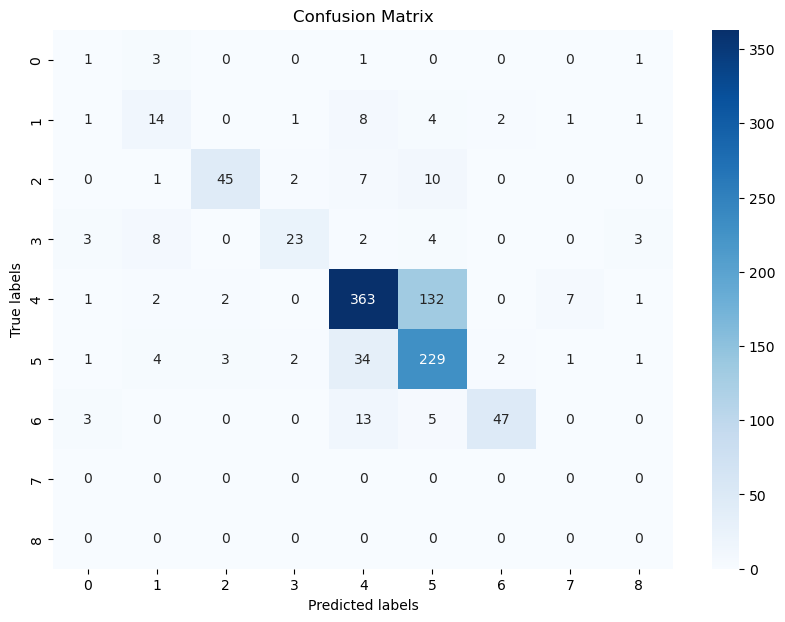

In [33]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    predictions, true_labels, probabilities = [], [], []
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            sigmoid_outputs = torch.sigmoid(outputs.logits)
            probabilities.append(sigmoid_outputs.cpu().numpy())
            pred_bools = (sigmoid_outputs > 0.5).cpu().numpy()
            predictions.append(pred_bools)
            true_labels.append(batch['labels'].cpu().numpy())

    # Flatten the predictions and true labels lists
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)
    probabilities = np.vstack(probabilities)

    # Calculate Metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='micro')
    recall = recall_score(true_labels, predictions, average='micro')
    f1 = f1_score(true_labels, predictions, average='micro')
    mse = mean_squared_error(true_labels, probabilities)
    test_error_rate = 1 - accuracy
    cm = confusion_matrix(true_labels.argmax(axis=1), predictions.argmax(axis=1))

    # Print Metrics
    print(f'Loss: {total_loss / len(data_loader):.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Test Error Rate: {test_error_rate:.4f}')

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Criterion for calculating the loss
criterion = torch.nn.BCEWithLogitsLoss()

# Example call to evaluate the model
evaluate_model(model, test_loader, criterion, device)


Roberta

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import numpy as np

# Load the dataset
df = pd.read_csv('labeled_comments_cleaned.csv')

# Fill NaN values with 'Unknown' and ensure all data are strings
df['level_0'] = df['level_0'].fillna('Unknown').astype(str)
df['level_1'] = df['level_1'].fillna('Unknown').astype(str)

# Combine the label columns into lists
df['combined_labels'] = df[['level_0', 'level_1']].apply(lambda x: [x['level_0'], x['level_1']], axis=1)

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['combined_labels'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df['comment_full_text'], labels, test_size=0.2, random_state=42)

# Define the Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Create DataLoaders
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/home/spati/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [35]:
# Load RoBERTa model configured for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=y_train.shape[1])
model.cuda()  # Move model to GPU if available

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
model.train()
for epoch in range(10):  # Number of training epochs
    for batch in train_loader:
        batch = {k: v.cuda() for k, v in batch.items()}  # Move batch to GPU
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/spati/.local/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.319690465927124
Epoch 2, Loss: 0.1531899869441986
Epoch 3, Loss: 0.4093390107154846
Epoch 4, Loss: 0.25796109437942505
Epoch 5, Loss: 0.0629008337855339
Epoch 6, Loss: 0.2283535897731781
Epoch 7, Loss: 0.13253238797187805
Epoch 8, Loss: 0.18672466278076172
Epoch 9, Loss: 0.07903402298688889
Epoch 10, Loss: 0.07440690696239471


In [36]:
model.save_pretrained('roberta_model')
tokenizer.save_pretrained('roberta_tokenizer')

('roberta_tokenizer/tokenizer_config.json',
 'roberta_tokenizer/special_tokens_map.json',
 'roberta_tokenizer/vocab.json',
 'roberta_tokenizer/merges.txt',
 'roberta_tokenizer/added_tokens.json')

Accuracy: 0.6677
Precision: 0.7694
Recall: 0.7312
F1 Score: 0.7498
Mean Squared Error: 0.0646
Test Error Rate: 0.3323


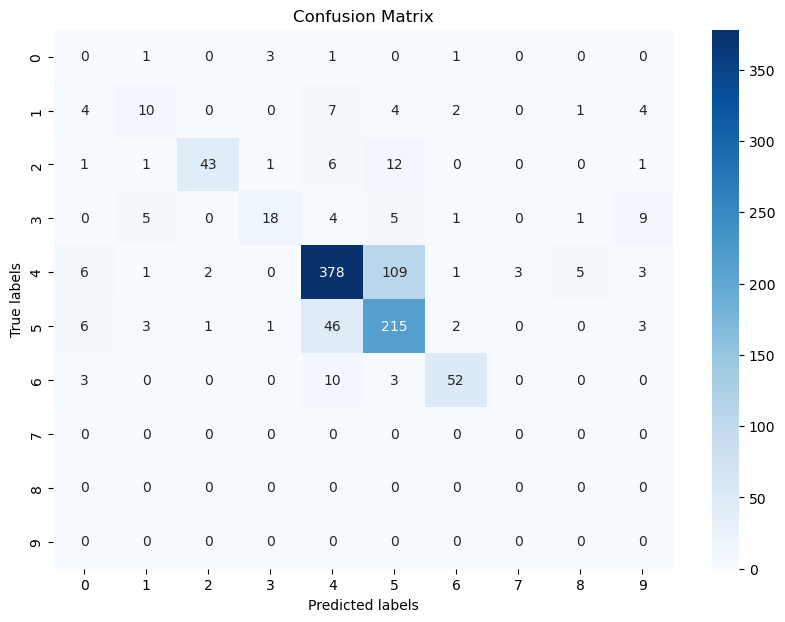

In [37]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions, true_labels, probabilities = [], [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.sigmoid(logits)
            predictions.extend((probs > 0.5).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())  # Ensure this is collecting data

    # Convert lists to numpy arrays for metric calculation
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)
    probabilities = np.vstack(probabilities)  # Ensure this has the correct shape

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='micro')
    recall = recall_score(true_labels, predictions, average='micro')
    f1 = f1_score(true_labels, predictions, average='micro')
    mse = mean_squared_error(true_labels, probabilities)
    test_error_rate = 1 - accuracy
    conf_matrix = confusion_matrix(true_labels.argmax(axis=1), predictions.argmax(axis=1))

    # Output the metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Test Error Rate: {test_error_rate:.4f}')

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Example call to evaluate the model
evaluate_model(model, test_loader, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


In [38]:
def predict_text(text, model, tokenizer, class_names):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.cuda() for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.sigmoid(outputs.logits).squeeze()
    predictions = (probabilities > 0.5).cpu().numpy()
    predicted_labels = [class_names[i] for i, pred in enumerate(predictions) if pred]
    return predicted_labels

# Example usage
text = "Texts in table cells can be adjusted to fit the page"
predicted_labels = predict_text(text, model, tokenizer, mlb.classes_)
print("Predicted Labels:", predicted_labels)


Predicted Labels: ['MODIFICATION', 'REQUESTED']
